In [1]:
pwd

'C:\\Users\\lyz\\Desktop\\数据科学基础展示'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta
train_data = pd.read_csv('../dsb/train/train_public.csv',encoding='gbk')
submit_example = pd.read_csv('../dsb/submit_example.csv',encoding='gbk')
test_public = pd.read_csv('../dsb/test_public.csv')
train_inte = pd.read_csv('../dsb/train/train_internet.csv')

In [3]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)

# 对'work_year'：将<1 year替换为0；>10 years替换为10

In [4]:
train_data['work_year'] 

0         3 years
1       10+ years
2       10+ years
3         6 years
4        < 1 year
          ...    
9995      7 years
9996      2 years
9997    10+ years
9998    10+ years
9999      7 years
Name: work_year, Length: 10000, dtype: object

In [28]:
a=" ye10+ars"
b=re.search('\d+', a).group()
b

'10'

In [5]:
def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['work_year']

TypeError: int() argument must be a string, a bytes-like object or a number, not 're.Match'

# 对'class'：将非数字特征依次映射为数字

In [6]:
train_data['class'] 

0       C
1       C
2       A
3       A
4       C
       ..
9995    B
9996    A
9997    B
9998    D
9999    C
Name: class, Length: 10000, dtype: object

In [7]:
class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)
train_data['class'] 
# baseline：train1_data['class'] = train1_data['class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})

0       3
1       3
2       1
3       1
4       3
       ..
9995    2
9996    1
9997    2
9998    4
9999    3
Name: class, Length: 10000, dtype: int64

# 对'earlies_credit_mon'：年月改为年月日，再转化为pd日期格式,对超上限数据-100，单列出年和月

In [8]:
train_data['earlies_credit_mon']

0        1-Dec
1       Apr-90
2       Oct-91
3        1-Jun
4        2-May
         ...  
9995     6-Feb
9996    May-97
9997    Feb-87
9998    Oct-92
9999     9-Feb
Name: earlies_credit_mon, Length: 10000, dtype: object

In [9]:
def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None: #被误判的数字在前，所以数字前面没有东西
        return '1-'+val
    return val + '-01'  #补足日期，以免被误判

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data['earlies_credit_mon'] 

0      2001-12-01
1      1990-04-01
2      1991-10-01
3      2001-06-01
4      2001-05-02
          ...    
9995   2001-02-06
9996   1997-05-01
9997   1987-02-01
9998   1992-10-01
9999   2001-02-09
Name: earlies_credit_mon, Length: 10000, dtype: datetime64[ns]

In [10]:
timeMax = pd.to_datetime('1-Dec-21')
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year

# 对'issue_date'：简单的日期格式转换，单列出月和日

In [11]:
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])

train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

In [12]:
#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year

train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])
train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek

# 对文字化特征'employer_type', 'industry'：embedding

In [13]:
cat_cols = ['employer_type', 'industry']
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    train_inte[col] = lbl.transform(train_inte[col])
    
train_data['employer_type']

0       3
1       3
2       3
3       1
4       3
       ..
9995    4
9996    3
9997    4
9998    3
9999    5
Name: employer_type, Length: 10000, dtype: int32

# 丢弃'issue_date', 'earlies_credit_mon'

In [14]:
col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )
train_inte = train_inte.drop(col_to_drop, axis=1 )

In [15]:
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})
# data = pd.concat( [train_data,test_public] )

In [16]:
tr_cols = set(train_data.columns)                               #读取train的列名集合   
same_col = list(tr_cols.intersection(set(train_inte.columns)))  #统计train和internet的相同列名集合    A.intersection(B)
train_inteSame = train_inte[same_col].copy()                    #复制internet中的相同列
  
Inte_add_cos = list(tr_cols.difference(set(same_col)))     #train比共同列多出了4条特征：'app_type', 'isDefault', 'known_dero', 'known_outstanding_loan'
for col in Inte_add_cos:
    train_inteSame[col] = np.nan                         #对internet数据加上train单独拥有的特征，且全部赋值为nan

注意：is_default是internet，isDefault是train

In [17]:
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ] #排除掉无意义特征
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,

        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #总迭代次数的10%，用于避免过拟合
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df
    
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [18]:
# 用train_data训练，以train_inteSame作为测试集
y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)   #5折交叉验证，打乱
oof_preds, IntePre, importances = train_model(train_data, train_inteSame, y, folds) #第二个值返回一个只有两列的df：'loan_id', 'isDefault'

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold  1 AUC : 0.892086


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's auc: 0.955419	training's binary_logloss: 0.224432	valid_1's auc: 0.888931	valid_1's binary_logloss: 0.289662
Fold  2 AUC : 0.890300


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's auc: 0.956116	training's binary_logloss: 0.219719	valid_1's auc: 0.874401	valid_1's binary_logloss: 0.311597
Fold  3 AUC : 0.875212


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's auc: 0.956786	training's binary_logloss: 0.218914	valid_1's auc: 0.866419	valid_1's binary_logloss: 0.321291
Fold  4 AUC : 0.866981


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold  5 AUC : 0.878520
Full AUC score 0.879476


In [19]:
IntePre['isDef'] = train_inte['is_default']
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDef'],IntePre.isDefault)   # roc_auc_score(lable,score)
## 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()   #找到所有预测小于0.05的贷款编号

C:\Users\lyz\AppData\Local\Temp/ipykernel_12776/3105031062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IntePre['isDef'] = train_inte['is_default']


In [20]:
 IntePre

,loan_id,isDefault,isDef
0,119262,0.297,1
1,369815,0.320,0
2,787833,0.430,0
3,671675,0.344,0
4,245160,0.220,0
...,...,...,...
749995,624287,0.233,0
749996,427602,0.009,0
749997,206828,0.371,0
749998,293912,0.307,0


In [21]:
len(InteId) 

59846

In [22]:
train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
# 设置数据源

train_inteSame['isDefault'] = train_inte['is_default']
use_te = train_inteSame[train_inteSame.loan_id.isin( InteId )].copy()  
data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True) # 把internet所有预测概率小于0.05的样本和train做拼接

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


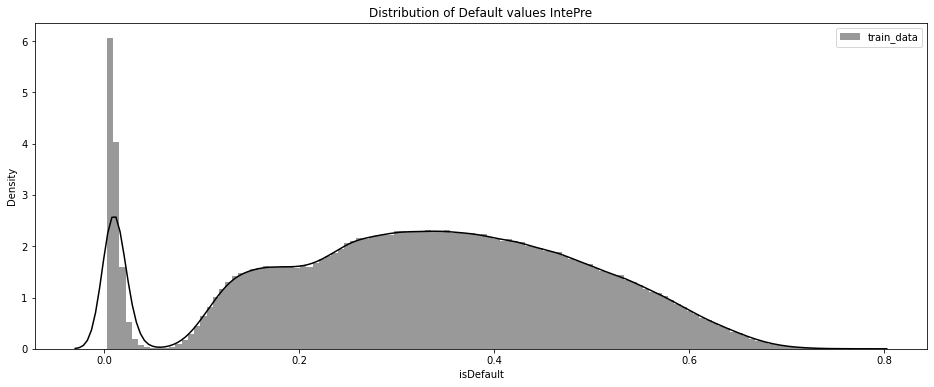

In [30]:
# IntePre.isDefault
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'],color="black", kde=True,bins=120, label='train_data')   #displot直方图
# sns.distplot(train_inte[col],color="red", kde=True,bins=120, label='train_inte')
plt.legend();plt.show()
train = data[data['isDefault'].notna()]
test  = data[data['isDefault'].isna()]

In [24]:
train

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,earliesCreditMon,earliesCreditYear,issue_date_month,issue_date_dayofweek,dataSourse
0,1040418,240418,31818.182,3,11.466,1174.910,3,3,13,3,0,1,2,193.000,13,2.430,0.000,556.364,649.091,3.000,0.000,0.000,7734.231,91.800,0,0.000,5.000,1.000,1.000,0.000,4.000,5.000,4.000,3,9927,0.000,0.000,12,2001,10,5,1
1,1025197,225197,28000.000,5,16.841,670.690,3,3,13,10,0,2,0,491.000,30,11.005,1.000,715.000,893.750,3.000,0.000,0.000,31329.000,54.800,1,0.000,40642.000,1.000,7.000,0.000,4.000,45.000,22.000,0,0,0.000,0.000,4,1990,6,5,1
2,1009360,209360,17272.727,3,8.900,603.320,1,3,3,10,1,0,4,459.000,8,6.409,0.000,774.545,903.636,5.000,0.000,0.000,18514.000,57.692,1,0.000,154.000,1.000,6.000,0.000,6.000,28.000,19.000,0,0,0.000,0.000,10,1991,1,2,1
3,1039708,239708,20000.000,3,4.788,602.300,1,1,10,6,0,1,0,157.000,8,9.205,0.000,750.000,875.000,3.000,0.000,0.000,20707.000,42.600,0,0.000,0.000,1.000,5.000,0.000,10.000,15.000,9.000,0,0,0.000,0.000,6,2001,7,2,1
4,1027483,227483,15272.727,3,12.790,470.310,3,3,2,0,2,1,0,38.000,21,15.578,0.000,609.091,710.606,15.000,0.000,0.000,14016.154,30.462,0,0.000,0.000,1.000,10.000,0.000,6.000,15.000,4.000,0,0,0.000,0.000,5,2001,7,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74841,731618,749936,30000.000,5,13.330,687.680,3,3,13,5,0,1,0,524.000,20,17.400,0.000,745.000,749.000,NaN,NaN,0.000,16679.000,63.400,0,NaN,0.000,1.000,5.000,0.000,2.000,7.000,6.000,1,17,4.762,0.000,4,1994,8,5,0
74842,500777,749971,3600.000,3,11.530,118.770,2,4,3,10,1,0,0,176.000,3,10.310,0.000,665.000,669.000,NaN,NaN,1.000,1713.000,63.400,0,NaN,0.000,1.000,2.000,0.000,18.000,16.000,7.000,11,231,127.125,0.000,10,1987,5,4,0
74843,194526,749986,12500.000,3,11.530,412.380,2,4,13,2,0,0,0,340.000,14,17.340,1.000,735.000,739.000,NaN,NaN,0.000,9776.000,21.600,0,NaN,0.000,1.000,6.000,0.000,4.000,34.000,22.000,20,2640,1553.315,0.000,8,2002,7,2,0
74844,588000,749992,10000.000,5,8.180,203.630,2,3,13,0,1,1,4,275.000,8,9.530,0.000,680.000,684.000,NaN,NaN,0.000,7184.000,86.600,0,NaN,4.000,1.000,3.000,0.000,18.000,6.000,4.000,29,290,122.642,0.000,9,2005,9,1,0


In [25]:
test

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,earliesCreditMon,earliesCreditYear,issue_date_month,issue_date_dayofweek,dataSourse
10000,1000575,200575,2890.909,3,10.791,88.010,2,2,1,5,0,1,0,314.000,0,23.040,0.000,745.000,869.167,7.000,0.000,0.000,8647.692,31.846,1,0.000,0.000,1.000,2.000,0.000,15.000,5.000,4.000,3,773,89.192,NaN,3,2001,12,4,1
10001,1028125,228125,7272.727,3,9.990,258.100,2,4,9,10,1,1,5,29.000,19,27.755,0.000,681.818,738.636,24.000,0.000,0.000,9406.154,18.277,0,0.000,6.000,1.000,8.000,0.000,8.000,29.000,14.000,1,1894,218.538,NaN,12,1999,7,2,1
10002,1010694,210694,26295.455,3,15.763,764.030,3,4,1,10,0,2,0,488.000,24,25.495,1.000,758.182,947.727,11.000,0.000,0.000,26414.769,62.300,1,0.000,268.000,1.000,6.000,0.000,4.000,10.000,6.000,1,5670,1221.231,NaN,4,1999,4,0,1
10003,1026712,226712,22690.909,5,19.305,524.300,4,4,12,10,0,2,0,489.000,30,10.620,0.000,572.727,620.455,8.000,0.000,0.000,1198.000,7.700,0,0.000,0.000,1.000,4.000,0.000,12.000,10.000,8.000,2,4800,443.077,NaN,7,2000,12,4,1
10004,1002895,202895,14545.455,3,7.139,490.320,1,1,13,1,0,0,2,418.000,45,6.611,0.000,638.182,691.364,15.000,0.000,0.000,3920.000,8.831,1,0.000,5.000,1.000,4.000,0.000,7.000,14.000,9.000,0,3516,649.108,NaN,5,2001,6,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1008856,208856,9454.545,5,12.015,183.470,3,3,2,0,1,0,0,48.000,10,14.900,0.000,568.636,710.795,11.000,0.000,0.000,5370.462,75.785,1,0.000,10595.000,1.000,NaN,NaN,NaN,NaN,NaN,0,0,0.000,NaN,7,2001,1,5,1
14996,1016651,216651,5500.000,3,7.970,172.280,1,3,8,5,1,0,0,31.000,2,12.160,0.000,796.364,995.455,5.000,0.000,0.000,6326.538,43.077,0,0.000,0.000,1.000,3.000,0.000,2.000,5.000,3.000,3,1564,0.000,NaN,4,2001,5,0,1
14997,1024140,224140,30545.455,3,8.900,889.090,1,0,8,10,0,2,0,464.000,37,21.550,0.000,710.000,769.167,17.000,0.000,0.000,63903.692,79.385,0,0.000,21735.000,1.000,8.000,0.000,17.000,20.000,14.000,2,5456,1510.892,NaN,10,1986,12,6,1
14998,1014316,214316,4090.909,3,6.030,152.180,1,3,10,10,0,2,0,566.000,30,13.222,0.000,709.091,768.182,7.000,0.000,0.000,2703.692,29.423,1,0.000,24272.000,1.000,1.000,0.000,6.000,10.000,10.000,3,223,41.169,NaN,3,1999,9,5,1


In [26]:
y = train['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, test_preds, importances = train_model(train, test, y, folds)
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('nn2.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold  1 AUC : 0.986243


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold  2 AUC : 0.984881


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold  3 AUC : 0.986452


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold  4 AUC : 0.983774


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold  5 AUC : 0.985528
Full AUC score 0.985262


C:\Users\lyz\AppData\Local\Temp/ipykernel_12776/1342879695.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_['isDefault'] = sub_preds


## 修改

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta
train_data = pd.read_csv('../dsb/train/train_public.csv',encoding='gbk')
submit_example = pd.read_csv('../dsb/submit_example.csv',encoding='gbk')
test_public = pd.read_csv('../dsb/test_public.csv')
train_inte = pd.read_csv('../dsb/train/train_internet.csv')

In [2]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
#             max_bin=250,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df
    
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'


class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}
timeMax = pd.to_datetime('1-Dec-21')
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])

In [3]:
#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])


train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year

In [4]:
###internet数据

train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year
cat_cols = ['employer_type', 'industry']

In [5]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    
    #Internet处理
    train_inte[col] = lbl.transform(train_inte[col])
    
# 'f1','policy_code','app_type' 这三个去掉是881
# ,'f1','policy_code','app_type'
col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )

In [6]:
##internet处理
train_inte = train_inte.drop(col_to_drop, axis=1 )
# 暂时不变
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})
# data = pd.concat( [train_data,test_public] )
tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_col].copy()

Inte_add_cos = list(tr_cols.difference(set(same_col)))
for col in Inte_add_cos:
    train_inteSame[col] = np.nan

In [7]:
y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, IntePre, importances = train_model(train_data, train_inteSame, y, folds)

IntePre['isDef'] = train_inte['is_default']
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDef'],IntePre.isDefault)
## 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
InteId = IntePre.loc[IntePre.isDefault<0.5, 'loan_id'].tolist()

train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
train_inteSame['isDefault'] = train_inte['is_default']
use_te = train_inteSame[train_inteSame.loan_id.isin( InteId )].copy()
data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

Fold  1 AUC : 0.892153


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[100]	training's auc: 0.954902	training's binary_logloss: 0.224771	valid_1's auc: 0.888907	valid_1's binary_logloss: 0.289767
Fold  2 AUC : 0.891066


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

Fold  3 AUC : 0.875276


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

Fold  4 AUC : 0.867667


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[100]	training's auc: 0.955868	training's binary_logloss: 0.223724	valid_1's auc: 0.87934	valid_1's binary_logloss: 0.300576
Fold  5 AUC : 0.880858
Full AUC score 0.880928


C:\Users\lyz\AppData\Local\Temp/ipykernel_12356/3865617851.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IntePre['isDef'] = train_inte['is_default']


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


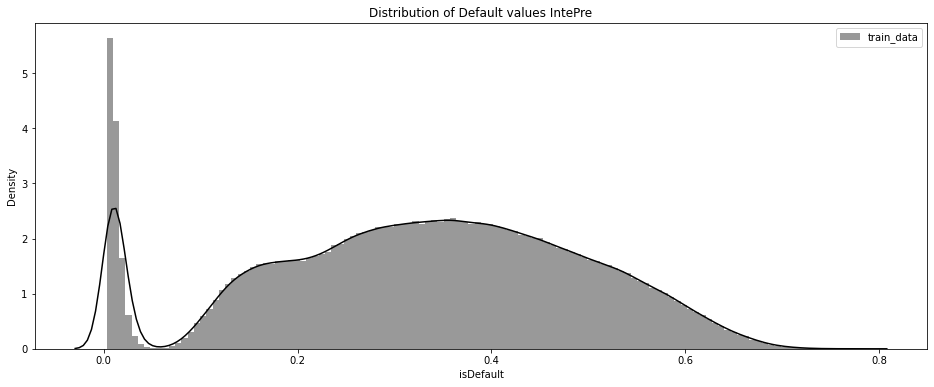

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[100]	training's auc: 0.786684	training's binary_logloss: 0.361803	valid_1's auc: 0.783086	valid_1's binary_logloss: 0.362276
[200]	training's auc: 0.794445	training's binary_logloss: 0.357002	valid_1's auc: 0.786422	valid_1's binary_logloss: 0.36005
[300]	training's auc: 0.799644	training's binary_logloss: 0.353861	valid_1's auc: 0.787789	valid_1's binary_logloss: 0.359185
[400]	training's auc: 0.803867	training's binary_logloss: 0.351273	valid_1's auc: 0.788303	valid_1's binary_logloss: 0.358833
[500]	training's auc: 0.807664	training's binary_logloss: 0.348953	valid_1's auc: 0.788497	valid_1's binary_logloss: 0.358701
[600]	training's auc: 0.811345	training's binary_logloss: 0.346681	valid_1's auc: 0.788648	valid_1's binary_logloss: 0.358627
[700]	training's auc: 0.814852	training's binary_logloss: 0.344513	valid_1's auc: 0.788734	valid_1's binary_logloss: 0.358573
Fold  1 AUC : 0.788759


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[100]	training's auc: 0.78676	training's binary_logloss: 0.36096	valid_1's auc: 0.782706	valid_1's binary_logloss: 0.365685
[200]	training's auc: 0.794279	training's binary_logloss: 0.356272	valid_1's auc: 0.78612	valid_1's binary_logloss: 0.363402
[300]	training's auc: 0.799554	training's binary_logloss: 0.353099	valid_1's auc: 0.787425	valid_1's binary_logloss: 0.362597
[400]	training's auc: 0.803725	training's binary_logloss: 0.350551	valid_1's auc: 0.788073	valid_1's binary_logloss: 0.362181
[500]	training's auc: 0.807415	training's binary_logloss: 0.348283	valid_1's auc: 0.788341	valid_1's binary_logloss: 0.362002
[600]	training's auc: 0.810659	training's binary_logloss: 0.346283	valid_1's auc: 0.788626	valid_1's binary_logloss: 0.361872
[700]	training's auc: 0.814251	training's binary_logloss: 0.344084	valid_1's auc: 0.788711	valid_1's binary_logloss: 0.361826
Fold  2 AUC : 0.788751


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[100]	training's auc: 0.786834	training's binary_logloss: 0.361788	valid_1's auc: 0.781802	valid_1's binary_logloss: 0.36265
[200]	training's auc: 0.794336	training's binary_logloss: 0.357075	valid_1's auc: 0.785213	valid_1's binary_logloss: 0.360555
[300]	training's auc: 0.799351	training's binary_logloss: 0.354011	valid_1's auc: 0.786581	valid_1's binary_logloss: 0.35977
[400]	training's auc: 0.803682	training's binary_logloss: 0.351349	valid_1's auc: 0.787423	valid_1's binary_logloss: 0.35931
[500]	training's auc: 0.807733	training's binary_logloss: 0.348872	valid_1's auc: 0.788013	valid_1's binary_logloss: 0.358995
[600]	training's auc: 0.811428	training's binary_logloss: 0.346584	valid_1's auc: 0.788365	valid_1's binary_logloss: 0.358822
Fold  3 AUC : 0.788361


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[100]	training's auc: 0.787345	training's binary_logloss: 0.360752	valid_1's auc: 0.781508	valid_1's binary_logloss: 0.365829
[200]	training's auc: 0.794751	training's binary_logloss: 0.35609	valid_1's auc: 0.78446	valid_1's binary_logloss: 0.363881
[300]	training's auc: 0.799455	training's binary_logloss: 0.353206	valid_1's auc: 0.785603	valid_1's binary_logloss: 0.363187
[400]	training's auc: 0.803499	training's binary_logloss: 0.350738	valid_1's auc: 0.786263	valid_1's binary_logloss: 0.362804
[500]	training's auc: 0.807607	training's binary_logloss: 0.348227	valid_1's auc: 0.78678	valid_1's binary_logloss: 0.362509
[600]	training's auc: 0.811114	training's binary_logloss: 0.346078	valid_1's auc: 0.786964	valid_1's binary_logloss: 0.362439
[700]	training's auc: 0.814341	training's binary_logloss: 0.344018	valid_1's auc: 0.78717	valid_1's binary_logloss: 0.362348
Fold  4 AUC : 0.787234


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[100]	training's auc: 0.786346	training's binary_logloss: 0.361888	valid_1's auc: 0.784657	valid_1's binary_logloss: 0.361713
[200]	training's auc: 0.793825	training's binary_logloss: 0.357269	valid_1's auc: 0.78766	valid_1's binary_logloss: 0.359694
[300]	training's auc: 0.79883	training's binary_logloss: 0.354254	valid_1's auc: 0.788999	valid_1's binary_logloss: 0.358867
[400]	training's auc: 0.802965	training's binary_logloss: 0.351715	valid_1's auc: 0.789668	valid_1's binary_logloss: 0.358438
[500]	training's auc: 0.806783	training's binary_logloss: 0.349342	valid_1's auc: 0.790086	valid_1's binary_logloss: 0.358206
[600]	training's auc: 0.810455	training's binary_logloss: 0.347084	valid_1's auc: 0.790397	valid_1's binary_logloss: 0.358028
[700]	training's auc: 0.813916	training's binary_logloss: 0.344943	valid_1's auc: 0.790666	valid_1's binary_logloss: 0.357905
[800]	training's auc: 0.817318	training's binary_logloss: 0.342813	valid_1's auc: 0.790792	valid_1's binary_logloss: 0.3

In [8]:
# IntePre.isDefault
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'],color="black", kde=True,bins=120, label='train_data')
# sns.distplot(train_inte[col],color="red", kde=True,bins=120, label='train_inte')
plt.legend();plt.show()
train = data[data['isDefault'].notna()]
test  = data[data['isDefault'].isna()]
# for col in ['sub_class', 'work_type']:
#     del train[col]
#     del test[col]


del data
del train_data,test_public


y = train['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, test_preds, importances = train_model(train, test, y, folds)
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('baseline891.csv', index=False)

In [ ]:
import xgboost as xgb

def train_model_xgb(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]

    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        model = xgb.XGBClassifier(objective = 'binary:logistic',
                                    max_depth = 5,
                                    n_estimators = 5000,
                                    learning_rate = 0.08,
                                    nthread = 4,
                                    subsample = 0.7,
                                    colsample_bytree = 0.7,
                                    min_child_weight = 3,
                                    n_jobs = -1)
        model.fit(trn_x, trn_y,
                    eval_set=[(trn_x, trn_y), (val_x, val_y)],
                    eval_metric='auc',
                    verbose=100,  # xgb verbose bool
                    early_stopping_rounds=50)
        oof_preds[val_idx] = model.predict_proba(val_x)[:,1]
        sub_preds += model.predict_proba(test_[feats], ntree_limit=model.best_ntree_limit)[:,1] / folds_.n_splits
        
        # clf.fit(trn_x, trn_y, 
        #         eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        #         eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
        #        )

        # oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        # sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del model, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df

In [ ]:
oof_preds, test_preds, importances = train_model_xgb(train, test, y, folds)

In [ ]:
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('xgb.csv', index=False)

In [ ]:
from catboost import CatBoostClassifier

def train_model_cat(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]

    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        cat_params = {'learning_rate': 0.08, 'depth': 9, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
              'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
        model = CatBoostClassifier(iterations=20000, eval_metric='AUC',
                                       **cat_params,
                                       loss_function='Logloss')
        model.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], cat_features=[], use_best_model=True,
                      verbose=100)
        oof_preds[val_idx] = model.predict_proba(val_x)[:,1]
        sub_preds += model.predict_proba(test_[feats])[:,1] / folds_.n_splits
        
        # clf.fit(trn_x, trn_y, 
        #         eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        #         eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
        #        )

        # oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        # sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del model, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']]

In [ ]:
oof_preds, test_preds = train_model_cat(train, test, y, folds)

In [ ]:
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('cat.csv', index=False)

In [ ]:
lgb = pd.read_csv('lgb.csv')
xgb = pd.read_csv('xgb.csv')
ctb = pd.read_csv('cat.csv')
sub = lgb.copy()

sub['isDefault']=(lgb['isDefault']+xgb['isDefault']+ctb['isDefault'])/3
sub['isDefault'] = sub['isDefault']
sub.to_csv("combine_model.csv", index=False)

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
#             max_bin=250,
            reg_alpha=.4,
            reg_lambda=.3,
            min_split_gain=.03,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=55  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df

In [ ]:
oof_preds, test_preds, importances = train_model(train, test, y, folds)

In [ ]:
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('lgb.csv', index=False)